# Librerias

In [177]:
%config IPCompleter.greedy=True
import numpy as np
from time import perf_counter
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#Librosa
from librosa import lpc
from librosa.effects import preemphasis
from librosa import resample
from librosa.util import peak_pick
from librosa.util import frame
from librosa import load

#Scipy
from scipy import spatial
from scipy.signal import medfilt

# Tablas de vocales y consonantes

In [178]:
male_vowel_dict = {
    (0, 0): " ",
    (240, 2400): "i",
    (235, 2100): "y",
    (390, 2300): "e",
    (370, 1900): "ø",
    (610, 1900): "ɛ",
    (585, 1710): "œ",
    (850, 1610): "a",
    (820, 1530): "ɶ",
    (750, 940): "ɑ",
    (700, 760): "ɒ",
    (600, 1170): "ʌ",
    (500, 700): "ɔ",
    (460, 1310): "ɤ",
    (360, 640): "o",
    (300, 1390): "w",
    (250, 595): "u"
}

male_sonorant_dict = {
    (250, 2200):"l",
    (150, 1600):"m",
    (150, 2100):"n",
    (500, 2400):"r",
    (3000, 4000):"sh",
}

male_fricative_dict = {
    (2000, 5000):"s",
    (2100, 3000):"z",
    (4100,0):"sh",
    (3200,4500):"f",
    (1500,5500):"j",
}



# Funciones

In [179]:
NUMBER_OF_SLOTS = 4

def GetPeaks(spectrum, fs, start_freq=150, end_freq=3400):
    start_indx = int(start_freq*(len(buffer)/fs)) #Start looking from start_freq
    end_indx = int(end_freq*(len(buffer)/fs))  #End search at end_freq
    peaks = peak_pick(spectrum[start_indx:end_indx], pre_max=2, post_max=2, pre_avg=3, post_avg=3, delta=0, wait=0)
    return (start_indx+peaks)*(fs/len(buffer))

def FormantsToPhoneme(f1,f2,sex, inv_dict):
    if sex == "male":
        keys_array = list(inv_dict.keys())
        tree = spatial.KDTree(keys_array)
        index = tree.query([(f1,f2)])[1][0]
        phoneme = inv_dict[keys_array[index]]
        return phoneme
    elif sex == "female": #change
        keys_array = list(male_vowel_inv_dict.keys())
        tree = spatial.KDTree(keys_array)
        index = tree.query([(f1,f2)])[1][0]
        vowel = male_vowel_inv_dict[keys_array[index]]
        return vowel
def most_frequent(input_list):
    occurence_count = Counter(input_list)
    return occurence_count.most_common(1)[0][0]

def SmoothPhonemes(ph_list, order=4):
    new_list = []
    for i in range(order,len(ph_list)):
        new_list.append( most_frequent( ph_list[i-order:i] ) )
    return new_list
        

# Cargo señal de audio y estimo formantes

Sample rate = 22050


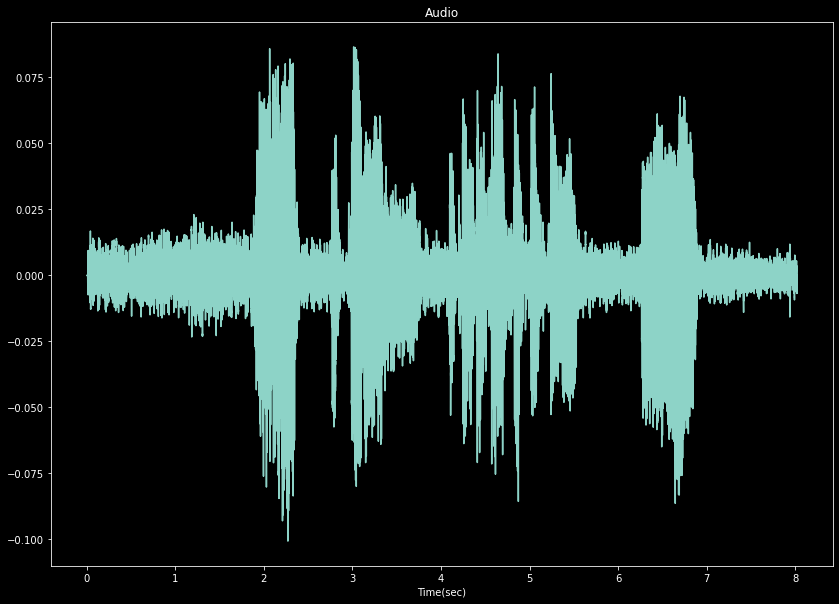

In [180]:
audio, sr = load("Audios/Hola buenas tardes.wav")
time_arr = np.linspace(start=0,stop=len(audio)/sr, num= len(audio))
#Visualizar datos
print("Sample rate = " + str(sr))
plt.figure(figsize=(14,10))
plt.title("Audio")
plt.xlabel("Time(sec)")
plt.plot(time_arr, audio)
plt.show()

In [181]:
class speech_features:
  def __init__(self, is_sound, is_voiced, is_lf, is_sonorant):
    self.is_sound = is_sound
    self.is_voiced = is_voiced
    self.is_lf = is_lf
    self.is_sonorant = is_sonorant

In [182]:
images_dict = {
    " ": "silence.jpeg",
    "i": "ee.jpg", #Vowels
    "y": "i-y.jpg",
    "e": "a-e-i.jpg",
    "ɛ": "a-e-i.jpg",
    "œ": "a-e-i.jpg",
    "a": "a-e-i.jpg",
    "ɶ": "a-e-i.jpg",
    "ɑ": "a-e-i.jpg",
    "ɒ": "a-e-i.jpg",
    "ʌ": "a-e-i.jpg",
    "ɔ": "o.jpg",
    "o": "u.jpg",
    "ɤ": "u.jpg",
    "ø": "a-e-i.jpg",
    "w": "u.jpg",
    "u": "u.jpg",
    "tpkc": "b-m-p.jpg", #Revisar
    "bdg": "c-d-g-k-n-s-x-z.jpg",
    "vz": "f-t-th-v.jpg",
    "n":"c-d-g-k-n-s-x-z.jpg", #Sonorants
    "m":"b-m-p.jpg",
    "l":"l.jpg",
    "sh":"j-ch-sh.jpg",
    "r":"r.jpg",
    "s":"c-d-g-k-n-s-x-z.jpg",#Fricatives
    "z":"c-d-g-k-n-s-x-z.jpg",
    "f":"f-t-th-v.jpg",
    "j":"j-ch-sh.jpg"
}

In [183]:
# speech_features.is_sound  --> sound/ silence
# speech_feature.is_voiced --> voiced/ unvoiced
# speech_features.is_lf --> low frequency/ high frequency
# speech_feature.sonorant --> sonorant/ vowel
# speech_feature.F1 --> F1
# speech_feature.F2 --> F2

past_status = 'silence'

def classifier(speech_features, spectrum, fs, sex="male"):
    global past_status
    if speech_features.is_sound:
        if speech_features.is_voiced:
            if speech_features.is_lf:
                if past_status == 'sound':
                    if speech_features.is_sonorant:
                        past_status = 'sound'
                        formants = GetPeaks(spectrum, fs, start_freq=100,end_freq=4500)
                        F1 = formants[0]
                        F2 = formants[1]
                        return FormantsToPhoneme(F1,F2,sex, male_sonorant_dict)
                    else: # vowel
                        past_status = 'sound'
                        formants = GetPeaks(spectrum, fs)
                        F1 = formants[0]
                        F2 = formants[1]
                        return FormantsToPhoneme(F1,F2,sex, male_vowel_dict)
                elif past_status == 'silence':
                    past_status = 'sound'
                    return 'bdg'              
            else: # hf
                past_status = 'sound'
                return 'vz'
        else: # unvoiced
            if past_status == 'sound':
                past_status = 'sound'
                formants = GetPeaks(spectrum, fs, start_freq=500,end_freq=6500)
                F1 = formants[0]
                F2 = formants[1]
                return FormantsToPhoneme(F1,F2,sex, male_fricative_dict)
            elif past_status == 'silence':
                past_status = 'sound'
                return 'tpkc'
    else: # silence
        past_status = 'silence' 
        return ' '

In [184]:
#Parameters
N = 256
new_fs = 1e4
lpc_order = 14
#Tresholds
energy_th = 5e-3
zc_threshold = 150 #FALTA DEFINIR
sonorant_th = 40 #FALTA DEFINIR
sonorant_zc_th = 10
epsilon = 1e-5
#Window audio
samples_n = int(256e-4*sr)
frames = frame(audio, samples_n, samples_n, axis=0)
images = []
time_taken = []
#Debugging
zero_crossings = []
voiced_list = []
phoneme_list = []
ratio_list = []
i=0

for buffer in frames:
    start_time = perf_counter()
    is_sound = False # done
    is_voiced = False # done
    is_lf = False # done
    is_sonorant = False
    windowed_frame = buffer * np.hanning(samples_n)
    
    #LPC y espectro
    hp_filtered = preemphasis(windowed_frame, coef=1)
    downsampled = resample(hp_filtered, sr, new_fs)
    coefs = lpc(downsampled, lpc_order) #Revisar si son coeficientes del filtro de error o del predictivo
    spectrum = 1/abs(np.fft.rfft(coefs,n=N))
    
    # Sound or Silence
    if windowed_frame.std() < energy_th:
        is_sound = False
    else:
        is_sound = True

    # High Frequency or Low Frequency
    zero_crosses = np.nonzero(np.diff(buffer> 0))[0]
    zero_crosses_count = zero_crosses.size
    if  zero_crosses_count >  zc_threshold:
        is_lf = False
    else:
        is_lf = True
    zero_crossings.append( (i, zero_crosses_count) )
    # Voiced or Unvoiced
    
    # 1. Calculate Zero-crossing count Nz, the number of zero crossing in the block
    Nz = zero_crosses_count
    # 2. Calculate Log energy Es
    Es = 10*np.log10(epsilon+sum(map(lambda x:x*x,buffer))/len(buffer))
    # 3. Normalized autocorrelation coefficient at unit sample delay, C1
    auto_corr_lag_1 = np.correlate(buffer, buffer, mode="full")[1]
    C1 = auto_corr_lag_1/np.sqrt((sum(map(lambda x:x*x,buffer[1:])))*(sum(map(lambda x:x*x,buffer[:-1]))))
    # 4. First LPC coefficient (12 poles)
    FirstLPCcoef = coefs[1]
    # 5. Normalized prediction error, Ep, expressed in DB
    sum_exp = 10
    error_spectrum = abs( np.fft.rfft(downsampled,N) )/spectrum
    Ep = np.dot(error_spectrum,error_spectrum) / (N*N)
    # LINK: https://www.clear.rice.edu/elec532/PROJECTS00/vocode/uv/uvdet.html
    # Means and Covariance Matrix
    silence_mean = np.array([9.6613, -38.1601, 0.989, 0.5084, -10.8084])
    silence_cov = np.array([[1.0000, 0.6760, -0.7077, -0.1904, 0.7208]
                  ,[0.6760, 1.0000, 0.6933, 0.2918, -0.9425]
                  ,[-0.7077, 0.6933, 1.0000, 0.3275, -0.8426]
                  ,[-0.1904, 0.2918, 0.3275, 1.0000, -0.2122]
                  ,[0.7208, -0.9425, -0.826, -0.2122, 1.0000]])
    
    unvoiced_mean = np.array([10.4286, -36.7536, 0.9598, 0.5243, -10.9076])
    unvoiced_cov = np.array([[1.0000, 0.6059, -0.4069, 0.4648, -0.4603]
                   ,[0.6059, 1.0000, -0.1713, 0.1916, -0.9337]
                   ,[-0.4069, -0.1713, 1.0000, 0.1990, -0.1685]
                   ,[0.4648, 0.1916, 0.1990, 1.0000, -0.2121]
                   ,[-0.4603, -0.9337, -0.1685, -0.2121, 1.0000]])
    
    voiced_mean = np.array([29.1853, -18.3327, 0.9826, 1.1977, -11.1256])
    voiced_cov = np.array([[1.0000, -0.2146, -0.8393, -0.3362, 0.3608]
                 ,[-0.2146, 1.0000, 0.1793, 0.6564, -0.7129]
                 ,[-0.8393, 0.1793, 1.0000, 0.3416, -0.5002]
                 ,[-0.3362, 0.6564, 0.3416, 1.0000, -0.4850]
                 ,[0.3608, -0.7129, -0.5002, -0.4850, 1.0000]])
    
    X = np.array([Nz, Es, C1, FirstLPCcoef, Ep])
    # Calculate distances (di)
    #d_silence = np.transpose(X-silence_mean)*np.linalg.inv(silence_cov)*(X-silence_mean)
    d_unvoiced = np.transpose(X-unvoiced_mean)@np.linalg.inv(unvoiced_cov)@(X-unvoiced_mean)
    d_voiced = np.transpose(X-voiced_mean)@np.linalg.inv(voiced_cov)@(X-voiced_mean)
    
    # Choose minimized distance category
    if d_unvoiced < d_voiced:
        is_voiced = False
        voiced_list.append(0)
    else:
        is_voiced = True
        voiced_list.append(1)
        
    # Sonorant or Vowel
    start_indx = int(640*(len(windowed_frame)/sr)) #Start calculation from 640Hz
    end_indx = int(2800*(len(windowed_frame)/sr))  #End calculation at 2800Hz
    low_freq_energy = np.dot(spectrum[start_indx:end_indx], spectrum[start_indx:end_indx]) #Energy
    
    start_indx = int(2000*(len(windowed_frame)/sr)) #Start calculation from 2000Hz
    end_indx = int(3000*(len(windowed_frame)/sr))  #End calculation at 300Hz
    high_freq_energy = np.dot(spectrum[start_indx:end_indx], spectrum[start_indx:end_indx]) #Energy
    
    ratio = low_freq_energy / high_freq_energy
    ratio_list.append(ratio)
    if (ratio < sonorant_th) and (zero_crosses_count <sonorant_zc_th):
        is_sonorant = True
    else:
        is_sonorant = False
    # Decision Tree
    sf = speech_features(is_sound, is_voiced, is_lf, is_sonorant)
    phoneme = classifier(sf,spectrum, sr)
    i = i+1
    phoneme_list.append(phoneme)
    time_taken.append(perf_counter() - start_time)
print(np.max(time_taken)*1000 )

6.473499999628984


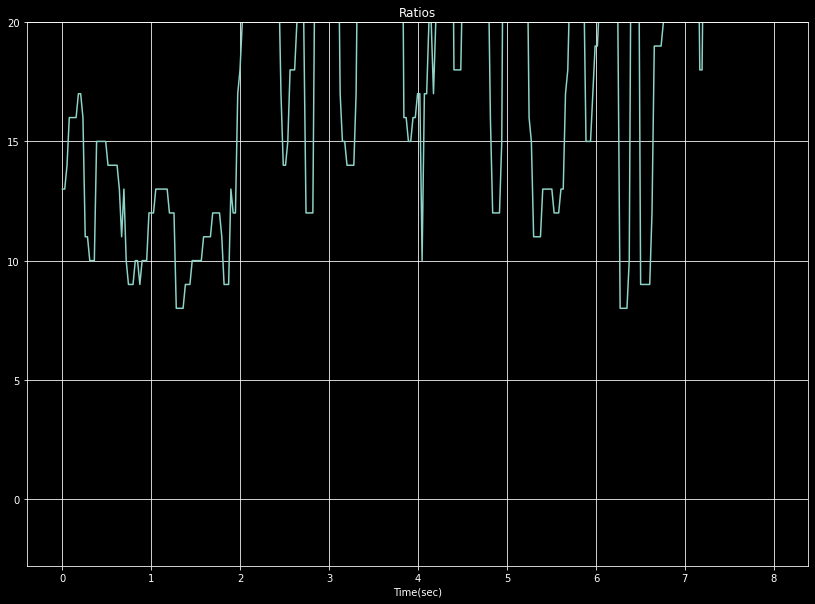

In [185]:
frame_id = []
cross = []
for crossing in zero_crossings:
    frame_id.append( crossing[0]*256e-4 )
    cross.append( crossing[1] )
plt.figure(figsize=(14,10))
plt.title("Ratios")
plt.xlabel("Time(sec)")
plt.grid(True)
#plt.plot(frame_id, cross)
plt.plot(frame_id, medfilt(np.array(cross),7) )
plt.ylim(top=20)
plt.show()

# Smoothing

In [186]:
smoothed_phonemes = SmoothPhonemes(phoneme_list, 10)
images = []
for phoneme in smoothed_phonemes:
    image = images_dict[phoneme]
    images.append(image)

In [187]:
print(smoothed_phonemes)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'm', 'm', 'm', 'm', 'm', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'tpkc', 'm', 'm', 'm', 'm', 'm', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'ʌ', 'ʌ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'ɤ', 'œ', 'œ', 'œ', 'œ', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', 'vz', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'bdg', 'vz', ' ', ' ', 'bdg', 'vz', 'vz', 'vz', 'vz', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'ʌ', 'ʌ', 'w', 'w', 'w', 'w', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 

# Generacion de video

In [188]:
import cv2
fps= int(1/256e-4)
size = (222, 220)
img_path = "bocas/"
img_array = []
for filename in images:
    img = cv2.imread(img_path+filename)
    resized = cv2.resize(img, size)
    img_array.append(resized)
 
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()